In [13]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])
from jax import vjp, linearize, grad
#from utils import *

In [53]:
def regularized_KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener, reg_factor=0.001):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10))) + reg_factor * np.sum(np.square(Y))

In [54]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9244, 50 iterations in 0.7766 sec
Iteration  100, KL divergence 0.9235, 50 iterations in 0.6710 sec
Iteration  150, KL divergence 1.0015, 50 iterations in 0.6845 sec
Iteration  200, KL divergence 0.9601, 50 iterations in 0.6824 sec
Iteration  250, KL divergence 0.8818, 50 iterations in 0.6834 sec
   --> Time elapsed: 3.50 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.2155, 50 iterations in 0.6712 sec
Iteration  100, KL divergence 0.1831, 50 iterations in 0.6699 sec
Iteration  150, KL divergence 0.1831, 50 iterations in 0.6698 sec
Iteration  200, KL divergence 0.1831, 50 iterations in 0.6722 sec
Iteration 

In [55]:
X.shape

(50, 50)

# Regularized

In [56]:
X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

In [57]:
dy, H, J = d_y_star_d_x_outer(regularized_KL_divergence, X, Y_star)
#H+= 1e-5*np.eye(len(H))

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

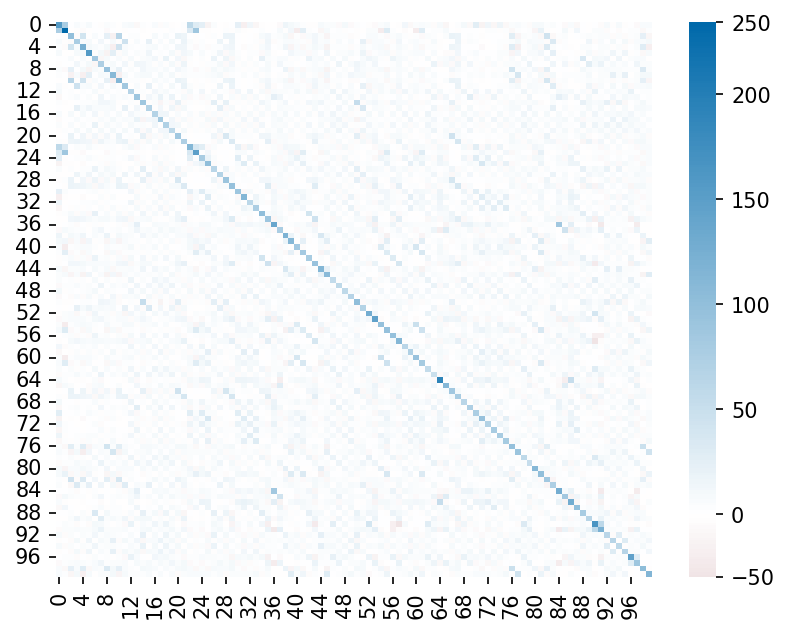

In [58]:
L, lower = jax.scipy.linalg.cho_factor(H, lower=True)
u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
L_t, lower = jax.scipy.linalg.cho_factor(H, lower=False)
H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)
f = plt.figure()
sns.heatmap(H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv), vmax=np.max(H_inv))))

In [59]:
fun = lambda x: regularized_KL_divergence(X_flat, x, X_unflattener, Y_unflattener)
#kld, f_vjp = vjp(fun, Y_flat)
_, f_vjp = vjp(grad(fun), Y_flat)
#_, f_jvp = jax.linearize(f_vjp, kld)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [60]:
def neumannApproximation_vis(f_vjp, v, Y, iterations):
    '''Neumann approximation of inverse-Hessian-vector product'''
    p = v
    for i in range(iterations):
        v -= f_vjp(v)[0]
        p += v
    return p


In [61]:
v_in = np.eye(len(Y_flat))
neumann_fun = lambda x: neumannApproximation_vis(f_vjp, x, Y_flat, 600)
H_inv_appr = vmap(neumann_fun)(v_in)

<AxesSubplot: >

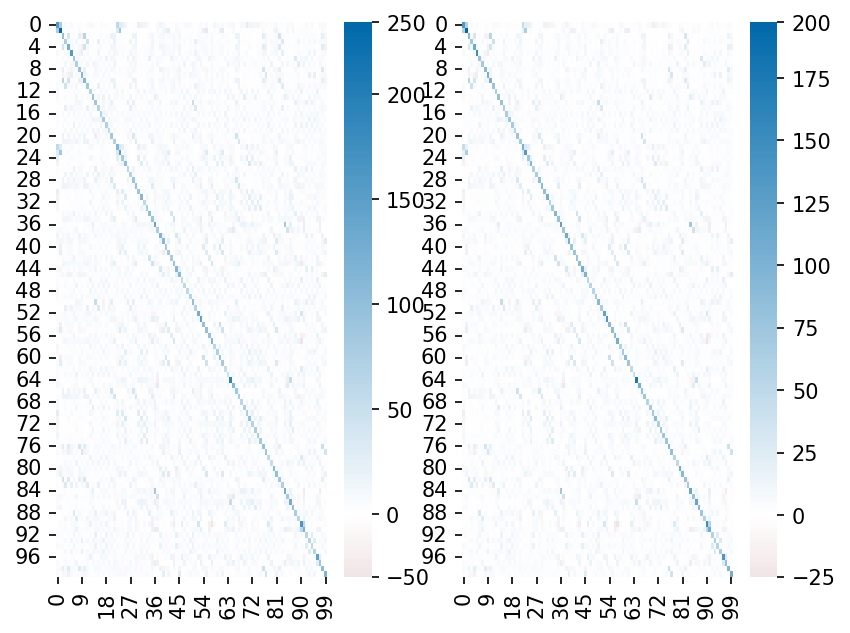

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv), vmax=np.max(H_inv))), ax=ax1)
sns.heatmap(H_inv_appr, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv_appr), vmax=np.max(H_inv_appr))), ax=ax2)

In [63]:
def neumannApproximation(f_vjp, v, iterations):
    '''Neumann approximation of inverse-Hessian-vector product'''
    p = v
    for i in range(iterations):
        v -= f_vjp(v)[0]
        p += v
    return p

In [ ]:
neumann_fun = lambda v: neumannApproximation(f_vjp, v, Y_flat, 200)

In [ ]:
funY = lambda y: regularized_KL_divergence(X_flat, y, X_unflattener, Y_unflattener)
funX = lambda x: regularized_KL_divergence(x, Y_flat, X_unflattener, Y_unflattener)
funXY = partial(regularized_KL_divergence, X_unflattener=X_unflattener, Y_unflattener=Y_unflattener)
_, hessian_vjp = vjp(grad(funY), Y_flat)
neumann_fun = lambda v: neumannApproximation(hessian_vjp, v, 200)
Jx_fun = lambda x: jax.grad(funXY, argnums=1)(x, Y_flat)
_, Jacobian_vjp = vjp(Jx_fun, X_flat)

In [ ]:
v_in = np.eye(len(X_flat))
Jx_fun2 = lambda y: jax.grad(funXY, argnums=0)(X_flat, y)
_, Jacobian_jvp = vjp(Jx_fun2, Y_flat)

In [ ]:
Jx_fun2(Y_flat).shape

In [ ]:
def compute_cov(neumann_fun, Jacobian_vjp, Jacobian_jvp, A, B, i, N, D):
    v1 = np.ravel(jax.nn.one_hot(np.array([i]), 2*N))
    print(v1.shape)
    v2 = neumann_fun(v1)
    print(v2.shape)
    v3 = Jacobian_vjp(v2)[0]
    print(v3.shape)
    v4 = np.ravel(np.dot(np.dot(A, np.reshape(v3, (N, D), 'C')), np.transpose(B)), 'C')
    print(v4.shape)
    v5 = Jacobian_jvp(v4)[0]
    print(v5)
    v6 = neumann_fun(v5)
    return v6

In [ ]:
N, D = X.shape
A = np.diag(np.ones(N))
B = np.diag(np.ones(D))

In [ ]:
compute_cov_fun = lambda i: compute_cov(neumann_fun, Jacobian_vjp, Jacobian_jvp, A, B, i, N, D)
cov = vmap(compute_cov_fun)(np.array([i for i in range(2*N)]))

In [ ]:
fig = plt.figure()
sns.heatmap(cov, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(cov), vmax=np.max(cov))))

In [ ]:
plt.scatter(Y_star[:, 0], Y_star[:, 1], c=y, cmap='tab10')

In [ ]:
from utils import equipotential_standard_normal, animate_ifd
S = equipotential_standard_normal(2 * Y_star.shape[0], 20)
L, lower = jax.scipy.linalg.cho_factor(cov+1e-5*np.eye(len(cov)), lower=True)
samples = np.transpose(np.transpose(np.dot(L, S))+Y_flat)
np.save('samples.npy', samples)
np.save('labels.npy', y)

In [ ]:
from utils import equipotential_standard_normal, animate_ifd
animate_ifd('samples.npy', 'labels.npy', 'animation.gif')